In [1]:
!nvidia-smi

Fri Mar 24 23:03:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:03:00.0 Off |                    0 |
| N/A   33C    P0    50W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import torch
import numpy as np
from simpletransformers.ner import NERModel, NERArgs
import pandas as pd
import datasets
from datasets import load_metric
from datasets import load_dataset

In [7]:
sample_txt = open("LST20/train/T00126.txt", "r")

In [8]:
sample_txt = sample_txt.read()

In [9]:
all_txt = sample_txt.split("\n")[0].split("\t") #concept

In [10]:
all_txt[1]

'NN'

In [11]:
lst20_train_path = "LST20/train/"

In [14]:
train_df = pd.DataFrame()
name_list = []
pos_list = []
ner1_list = []
ner2_list = []

for file_text in tqdm(os.listdir(lst20_train_path)):
    path = lst20_train_path + file_text
    if path.endswith("txt"):
        sample_text = open(path)
        sample_text = sample_text.read()
        n_txt = len(sample_text.split("\n"))
        for i in range(n_txt):
            all_txt = sample_text.split("\n")[i].split("\t") #concept
            if len(all_txt)>1 :
                name_list.append(all_txt[0])
                pos_list.append(all_txt[1])
                ner1_list.append(all_txt[2])
                ner2_list.append(all_txt[3])
            else:
                pass
        else:
            pass
    # print(file_text)

  0%|          | 0/3795 [00:00<?, ?it/s]

In [15]:
train_df["name"] = name_list
train_df["pos"] = pos_list
train_df["ner1"] = ner1_list
train_df["ner2"] = ner2_list

In [16]:
train_df

,name,pos,ner1,ner2
0,ธ.กสิกรไทย,NN,B_ORG,B_CLS
1,จับ,VV,O,I_CLS
2,มือ,NN,O,I_CLS
3,เวอริไซน์,NN,B_ORG,I_CLS
4,_,PU,O,I_CLS
...,...,...,...,...
2714721,ตาม,PS,O,I_CLS
2714722,ราคา,NN,O,I_CLS
2714723,ตลาด,NN,O,I_CLS
2714724,รวม,VV,O,I_CLS


In [17]:
lst20_eval_path = "LST20/eval/"

eval_df = pd.DataFrame()
eval_name_list = []
eval_pos_list = []
eval_ner1_list = []
eval_ner2_list = []

for file_text in tqdm(os.listdir(lst20_eval_path)):
    path = lst20_eval_path + file_text
    if path.endswith("txt"):
        sample_text = open(path)
        sample_text = sample_text.read()
        n_txt = len(sample_text.split("\n"))
        for i in range(n_txt):
            all_txt = sample_text.split("\n")[i].split("\t") #concept
            if len(all_txt)>1 :
                eval_name_list.append(all_txt[0])
                eval_pos_list.append(all_txt[1])
                eval_ner1_list.append(all_txt[2])
                eval_ner2_list.append(all_txt[3])
            else:
                pass
        else:
            pass
    # print(file_text)

  0%|          | 0/475 [00:00<?, ?it/s]

In [18]:
eval_df["name"] = eval_name_list
eval_df["pos"] = eval_pos_list
eval_df["ner1"] = eval_ner1_list
eval_df["ner2"] = eval_ner2_list

In [19]:
eval_df

,name,pos,ner1,ner2
0,นายก,NN,O,B_CLS
1,ฯ,PU,O,I_CLS
2,_,PU,O,I_CLS
3,ย้ำ,VV,O,I_CLS
4,_,PU,O,I_CLS
...,...,...,...,...
240855,ตำแหน่ง,NN,O,I_CLS
240856,หัวหน้า,NN,O,I_CLS
240857,พรรค,NN,B_ORG,I_CLS
240858,เพื่อ,PS,I_ORG,I_CLS


In [20]:
new_train_df = train_df[["name","pos"]]
new_eval_df = eval_df[["name", "pos"]]

In [21]:
new_train_df = new_train_df.rename(columns={"name":"text", "pos":"label"})
new_eval_df = new_eval_df.rename(columns={"name":"text", "pos":"label"})

<AxesSubplot: >

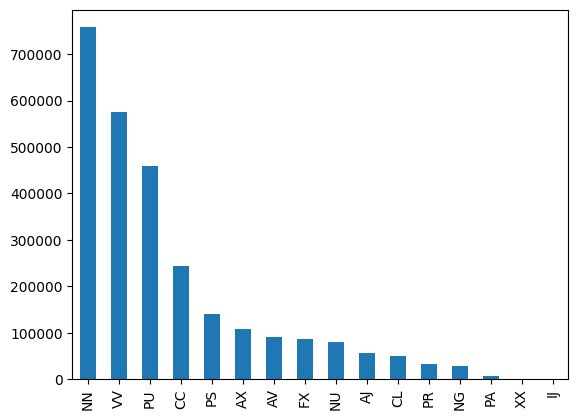

In [22]:
new_train_df['label'].value_counts().plot(kind='bar')

<AxesSubplot: >

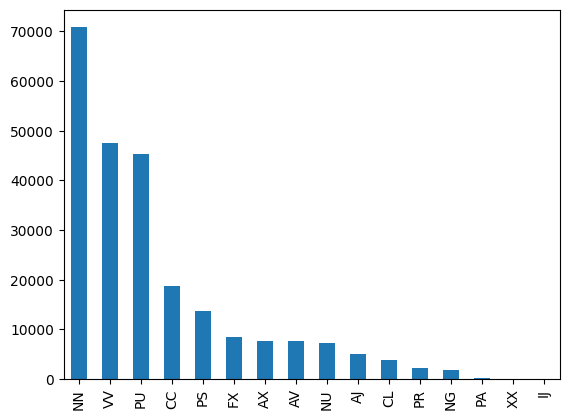

In [23]:
new_eval_df['label'].value_counts().plot(kind='bar')

In [24]:
labels = new_train_df['label'].unique()
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}
labels

array(['NN', 'VV', 'PU', 'FX', 'AJ', 'NU', 'CL', 'CC', 'NG', 'PS', 'AX',
       'AV', 'PR', 'PA', 'IJ', 'XX'], dtype=object)

In [25]:
new_train_df['label'] = new_train_df['label'].apply(lambda label:label2id[label])
new_train_df['text'] = new_train_df['text'].apply(lambda text:' '.join(text.split()).lower())
new_train_df.head()

,text,label
0,ธ.กสิกรไทย,0
1,จับ,1
2,มือ,0
3,เวอริไซน์,0
4,_,2


In [26]:
new_eval_df['label'] = new_eval_df['label'].apply(lambda label:label2id[label])
new_eval_df['text'] = new_eval_df['text'].apply(lambda text:' '.join(text.split()).lower())
new_eval_df.head()

,text,label
0,นายก,0
1,ฯ,2
2,_,2
3,ย้ำ,1
4,_,2


In [38]:
custom_labels = ['AJ', 'AV', 'AX', 'CC', 'CL', 'FX', 'IJ', 'NG', 'NN', 'NU', 'PA', 'PR', 'PS', 'PU', 'VV', 'XX']

### เริ่มใช้ data จากอันนี้

In [3]:
lst20 = load_dataset("lst20", data_dir="LST20")
train_df2 = pd.DataFrame(lst20['train'])
validation_df2 = pd.DataFrame(lst20['validation'])
test_df2 = pd.DataFrame(lst20['test'])

Found cached dataset lst20 (/home/superai023/.cache/huggingface/datasets/lst20/default-data_dir=LST20/0.0.0/e1b2a921fb011578ab43ddbbf789f3c500d62cb2df8ae4ed4b60bae8e4c0d3ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
POS_TAGS = lst20["train"].features["pos_tags"].feature.names
lst20["train"].features["pos_tags"].feature.names

['NN',
 'VV',
 'PU',
 'CC',
 'PS',
 'AX',
 'AV',
 'FX',
 'NU',
 'AJ',
 'CL',
 'PR',
 'NG',
 'PA',
 'XX',
 'IJ']

In [5]:
def to_df(df):
    id=[]
    tokens=[]
    pos=[]
    for index in range(len(df)):
        for tok in range(len(df['tokens'][index])):
            id.append(index)
            tokens.append(df['tokens'][index][tok])
            pos.append(POS_TAGS[df['pos_tags'][index][tok]])
    return pd.DataFrame({"sentence_id": id, "words": tokens, "labels": pos})

In [6]:
train_data = to_df(train_df2)
val_data = to_df(validation_df2)
test_data = to_df(test_df2)

In [7]:
val_data.head(30)

,sentence_id,words,labels
0,0,สลด,VV
1,0,ผัว,NN
2,0,เมีย,NN
3,0,เฒ่า,NN
4,0,ถูก,AX
5,0,ไฟ,NN
6,0,ช็อต,VV
7,0,กอด,VV
8,0,กัน,AV
9,0,ตาย,VV


In [8]:
model_name = "xlm-roberta-base"

In [9]:
# Configure the model
ner_args = NERArgs()
ner_args.train_batch_size = 64
ner_args.eval_batch_size = 64
ner_args.use_multiprocessing = True 
ner_args.evaluate_during_training = True
ner_args.overwrite_output_dir = True
ner_args.num_train_epochs = 5
ner_args.max_seq_length = 128

# Stop Early
ner_args.use_early_stopping = True
ner_args.early_stopping_delta = 0.01
# ner_args.early_stopping_metric = "mcc"
ner_args.early_stopping_metric_minimize = False
ner_args.early_stopping_patience = 5
ner_args.evaluate_during_training_steps = 1000

model = NERModel(
     "auto", model_name, args=ner_args, labels=POS_TAGS
)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-st

In [10]:
# Train the model
model.train_model(train_data, eval_data=val_data)

/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/990 [00:00<?, ?it/s]

/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AX seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PU seems not to be NE tag.
  warnings.warn('{} seems not to be

Running Epoch 1 of 5:   0%|          | 0/990 [00:00<?, ?it/s]

/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AX seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PU seems not to be NE tag.
  warnings.warn('{} seems not to be

  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AX seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PU seems not to be NE tag.
  warnings.warn('{} seems not to be

Running Epoch 2 of 5:   0%|          | 0/990 [00:00<?, ?it/s]

/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AX seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PU seems not to be NE tag.
  warnings.warn('{} seems not to be

  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AX seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PU seems not to be NE tag.
  warnings.warn('{} seems not to be

Running Epoch 3 of 5:   0%|          | 0/990 [00:00<?, ?it/s]

/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AX seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PU seems not to be NE tag.
  warnings.warn('{} seems not to be

  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AX seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PU seems not to be NE tag.
  warnings.warn('{} seems not to be

Running Epoch 4 of 5:   0%|          | 0/990 [00:00<?, ?it/s]

/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AX seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PU seems not to be NE tag.
  warnings.warn('{} seems not to be

  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AX seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PU seems not to be NE tag.
  warnings.warn('{} seems not to be

(4950,
 defaultdict(list,
             {'global_step': [990,
               1000,
               1980,
               2000,
               2970,
               3000,
               3960,
               4000,
               4950],
              'train_loss': [0.11155413836240768,
               0.09572186321020126,
               0.06548457592725754,
               0.07548873871564865,
               0.041757550090551376,
               0.06851186603307724,
               0.05627427622675896,
               0.07009167969226837,
               0.04540044441819191],
              'eval_loss': [0.09899854037741368,
               0.09712003184143793,
               0.09434240154752677,
               0.09744996748949317,
               0.09225686061704023,
               0.09067362305623564,
               0.09103432043709538,
               0.09171859676611017,
               0.09289782085794616],
              'precision': [0.9524399306415655,
               0.9525327685557051,
         

In [11]:
# Evaluate the model
result, model_outputs, preds_list = model.eval_model(val_data)

/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/12 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AX seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AV seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/superai023/.conda/envs/newpt/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PU seems not to be NE tag.
  warnings.warn('{} seems not to be

In [20]:
val_data

,sentence_id,words,labels
0,0,สลด,VV
1,0,ผัว,NN
2,0,เมีย,NN
3,0,เฒ่า,NN
4,0,ถูก,AX
...,...,...,...
240855,5619,จะ,AX
240856,5619,ขอ,VV
240857,5619,ไว้,AV
240858,5619,ดูแล,VV


In [12]:
result

{'eval_loss': 0.09289782085794616,
 'precision': 0.9544511011728968,
 'recall': 0.955117343406083,
 'f1_score': 0.9547841060646134}

In [13]:
print(preds_list[:1])
val_data.loc[val_data['sentence_id'] == 0]

[['VV', 'NN', 'NN', 'NN', 'AX', 'NN', 'VV', 'VV', 'PR', 'VV', 'PU', 'VV', 'NN', 'VV', 'PU', 'NN', 'VV']]


,sentence_id,words,labels
0,0,สลด,VV
1,0,ผัว,NN
2,0,เมีย,NN
3,0,เฒ่า,NN
4,0,ถูก,AX
5,0,ไฟ,NN
6,0,ช็อต,VV
7,0,กอด,VV
8,0,กัน,AV
9,0,ตาย,VV


In [14]:
test_data

,sentence_id,words,labels
0,0,จีน,NN
1,0,-,PU
2,0,อินเดีย,NN
3,0,เสี่ยง,VV
4,0,สูญเสีย,VV
...,...,...,...
207273,5249,ครหา,VV
207274,5249,เกี่ยวกับ,VV
207275,5249,ความ,FX
207276,5249,ไม่,NG


In [15]:
test_df2

,id,fname,tokens,pos_tags,ner_tags,clause_tags
0,0,T11046.txt,"[จีน, -, อินเดีย, เสี่ยง, สูญเสีย, จาก, ภัย, ธ...","[0, 2, 0, 1, 1, 4, 0, 0, 1, 6]","[4, 0, 4, 0, 0, 0, 0, 0, 0, 0]","[1, 2, 2, 2, 2, 2, 2, 2, 2, 3]"
1,1,T11046.txt,"[เจนีวา, _, -, _, จีน, _, อินเดีย, _, และ, ประ...","[0, 2, 2, 2, 0, 2, 0, 2, 3, 0, 3, 1, 0, 0, 1, ...","[4, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
2,2,T11046.txt,"[ใน, รายงาน, ความ, เสี่ยง, จาก, ภัย, ธรรมชาติ,...","[4, 1, 7, 1, 4, 0, 0, 2, 3, 1, 4, 0, 4, 0, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 2, 2, 2, 2, 3, 0, 1, 2, 2, 2, 2, 3, 0, ..."
3,3,T11046.txt,"[ประชากร, กลุ่ม, เสี่ยง, ส่วนใหญ่, _, อาศัย, อ...","[0, 10, 1, 0, 2, 1, 1, 4, 4, 0, 0, 2, 1, 3, 2,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, ..."
4,0,T11058.txt,"[เกิด, เหตุ, พายุ, พัด, ถล่ม, จีน, _, ทำให้, ม...","[1, 0, 0, 1, 1, 0, 2, 3, 1, 7, 1, 7, 1, 2, 8, ...","[0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, ...","[1, 2, 2, 2, 2, 3, 0, 1, 2, 2, 2, 2, 2, 2, 2, ..."
...,...,...,...,...,...,...
5245,15,T13476.txt,"[โดย, นาย, ไพโรจน์, _, กล่าว, ว่า, _, การ, แต่...","[3, 0, 0, 2, 1, 3, 2, 7, 1, 10, 9, 2, 1, 7, 12...","[0, 10, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 2, 2, 2, 2, 3, 0, 1, 2, 2, 2, 2, 2, 2, 2, ..."
5246,16,T13476.txt,"[และ, ที่, สำคัญ, ที่สุด, คือ, _, นาย, มานิต, ...","[3, 3, 1, 6, 1, 2, 0, 0, 1, 0, 9, 3, 1, 7, 1, ...","[0, 0, 0, 0, 0, 0, 10, 8, 0, 0, 0, 0, 0, 0, 0,...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, ..."
5247,17,T13476.txt,"[**, _, เชิญ, "", ชวรัตน์, "", _, ชี้แจง, _, 25,...","[2, 2, 1, 2, 0, 2, 2, 1, 2, 8, 2, 0, 9]","[0, 0, 0, 0, 8, 0, 0, 0, 0, 3, 13, 23, 0]","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3]"
5248,18,T13476.txt,"[นาย, ไพโรจน์, _, กล่าว, ด้วย, ว่า, _, คณะ, กร...","[0, 0, 2, 1, 6, 3, 2, 0, 0, 5, 1, 7, 3, 1, 4, ...","[10, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 2, 2, 2, 2, 3, 0, 1, 2, 2, 2, 3, 1, 2, 2, ..."


In [16]:
# submission_text = open("pos_test.txt", "r")
texts_test_raw = []
f = open('/project/lt900038-ai23tn/kaggle/nlp_pos_tagging/pos_test.txt', "r")
file_data = f.readlines()
for line in file_data:
    line = line.strip().replace(u'\xa0', u'')
    texts_test_raw.append(line)

In [17]:
texts_test_raw = texts_test_raw[:-1]

In [18]:
# n_sub = len(submission_text.split("\n"))
# text_list = []
# for i in tqdm(range(n_sub)):
#     text = submission_text.split("\n")[i]
#     if text == '':
#         text = "_"
#         text_list.append(text)
#     else:
#         text_list.append(text)
def blank_space(x):
    if x == '':
        x = '_'
    return x

for i in range(len(texts_test_raw)):
    texts_test_raw[i] = blank_space(texts_test_raw[i])

In [23]:
len(texts_test_raw)

103913

In [24]:
texts_test_raw

['อย่างไรก็ตาม',
 'เครื่อง',
 'บิน',
 'แอร์บัส',
 '_',
 'เอ',
 '380',
 'ได้',
 'ถึง',
 'ที่',
 'หมาย',
 'ที่',
 'ท่าอากาศยาน',
 'เชียงใหม่',
 'ใน',
 'เวลา',
 '_',
 '14.50',
 '_',
 'น.',
 'โดย',
 'ใช้',
 'เวลา',
 'บิน',
 'ประมาณ',
 '1',
 'ชั่วโมง',
 '_',
 'มูลนิธิสืบฯ',
 'พอใจ',
 'ฟื้น',
 'ป่าห้วยขาแข้ง',
 'มี',
 'เสือโคร่ง',
 'มาก',
 'อันดับ',
 '2',
 'โลก',
 '_',
 '1',
 '_',
 'กันยายน',
 '_',
 '2550',
 '17.31',
 'น.',
 '_',
 'ประธาน',
 'มูลนิธิ',
 'สืบ',
 'นาคะเสถียร',
 'พอใจ',
 'ป่า',
 'ห้วยขาแข้ง',
 'ฟื้นตัว',
 'พบ',
 'เสือโคร่ง',
 '2-3',
 'ตัว',
 'ต่อ',
 '100',
 'ตาราง',
 'กิโลเมตร',
 'มาก',
 'อันดับ',
 'ที่',
 '_',
 '2',
 'ของ',
 'โลก',
 'ตั้ง',
 'เป้า',
 '5',
 'ปี',
 'ขึ้น',
 'อันดับ',
 '1',
 'แสดง',
 'ถึง',
 'ยัง',
 'มี',
 'สัตว์',
 'และ',
 'พืช',
 'ชนิด',
 'อื่น',
 'ๆ',
 'อุดมสมบูรณ์',
 '_',
 'วอน',
 'รัฐ',
 'เข้าใจ',
 'ปรับ',
 'นโยบาย',
 'จับตา',
 'ค้าน',
 'กฎหมาย',
 'เปิด',
 'ป่า',
 '_',
 '(',
 '1',
 'ก.ย.',
 ')',
 'นาง',
 'รตยา',
 '_',
 'จันทรเทียร',
 'ประธาน',
 'มูลนิธิ',
 '

In [21]:
sub_df = pd.DataFrame()
sub_df["text"] = texts_test_raw

In [23]:
sub_df

,text
0,อย่างไรก็ตาม
1,เครื่อง
2,บิน
3,แอร์บัส
4,_
...,...
103908,เตรียม
103909,พร้อม
103910,รับ
103911,การ


In [28]:
sub_df["text"].iloc[0:4]

0    อย่างไรก็ตาม
1         เครื่อง
2             บิน
3         แอร์บัส
Name: text, dtype: object

In [31]:
pred_test_sub,raw_outputs_test= model.predict(sub_df["text"])

  0%|          | 0/125 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1624 [00:00<?, ?it/s]

In [34]:
pred_test_sub

[[{'อย่างไรก็ตาม': 'CC'}],
 [{'เครื่อง': 'NN'}],
 [{'บิน': 'VV'}],
 [{'แอร์บัส': 'NN'}],
 [{'_': 'PU'}],
 [{'เอ': 'NN'}],
 [{'380': 'NU'}],
 [{'ได้': 'AX'}],
 [{'ถึง': 'PS'}],
 [{'ที่': 'PS'}],
 [{'หมาย': 'NN'}],
 [{'ที่': 'PS'}],
 [{'ท่าอากาศยาน': 'NN'}],
 [{'เชียงใหม่': 'NN'}],
 [{'ใน': 'PS'}],
 [{'เวลา': 'NN'}],
 [{'_': 'PU'}],
 [{'14.50': 'NU'}],
 [{'_': 'PU'}],
 [{'น.': 'NN'}],
 [{'โดย': 'CC'}],
 [{'ใช้': 'VV'}],
 [{'เวลา': 'NN'}],
 [{'บิน': 'VV'}],
 [{'ประมาณ': 'AJ'}],
 [{'1': 'NU'}],
 [{'ชั่วโมง': 'CL'}],
 [{'_': 'PU'}],
 [{'มูลนิธิสืบฯ': 'NN'}],
 [{'พอใจ': 'VV'}],
 [{'ฟื้น': 'VV'}],
 [{'ป่าห้วยขาแข้ง': 'NN'}],
 [{'มี': 'VV'}],
 [{'เสือโคร่ง': 'NN'}],
 [{'มาก': 'VV'}],
 [{'อันดับ': 'NN'}],
 [{'2': 'NU'}],
 [{'โลก': 'NN'}],
 [{'_': 'PU'}],
 [{'1': 'NU'}],
 [{'_': 'PU'}],
 [{'กันยายน': 'NN'}],
 [{'_': 'PU'}],
 [{'2550': 'NU'}],
 [{'17.31': 'NU'}],
 [{'น.': 'NN'}],
 [{'_': 'PU'}],
 [{'ประธาน': 'NN'}],
 [{'มูลนิธิ': 'NN'}],
 [{'สืบ': 'VV'}],
 [{'นาคะเสถียร': 'NN'}],
 [{'พอใจ': 'VV'}

In [39]:
pred_test_sub[1][0]["เครื่อง"]

'NN'

In [40]:
new_pred_list = []
for i in tqdm(range(len(texts_test_raw))):
    pred_label = pred_test_sub[i][0][texts_test_raw[i]]
    new_pred_list.append(pred_label)

  0%|          | 0/103913 [00:00<?, ?it/s]

In [49]:
id_list = []
for i in range(1,len(texts_test_raw)+1):
    id_list.append(i)

In [50]:
submission_df = pd.DataFrame()
submission_df["Id"] = id_list
submission_df["Predicted"] = new_pred_list

In [53]:
submission_df.to_csv("submission_df_nlp.csv",index=False)